# Example - 2D Plane


This is my notebook where I play around with all things normalizing flow with pyro. I use the following packages:

* PyTorch
* Pyro
* PyTorch Lightning
* Wandb

In [ ]:
#@title Install Packages
# %%capture

!pip install --upgrade --quiet pyro-ppl tqdm wandb corner loguru pytorch-lightning lightning-bolts torchtyping einops plum-dispatch pyyaml==5.4.1 nflows
!pip install --upgrade --quiet scipy

     |████████████████████████████████| 678 kB 5.2 MB/s 
     |████████████████████████████████| 1.7 MB 37.1 MB/s 
     |████████████████████████████████| 57 kB 4.6 MB/s 
     |████████████████████████████████| 524 kB 46.5 MB/s 
     |████████████████████████████████| 282 kB 45.3 MB/s 
     |████████████████████████████████| 470 kB 46.6 MB/s 
     |████████████████████████████████| 636 kB 46.1 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 180 kB 48.7 MB/s 
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 140 kB 48.7 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 829 kB 37.4 MB/s 
     |████████████████████████████████| 132 kB 44.3 MB/s 
     |████████████████████████████████| 329 kB 46.2 MB/s 
     |████████████████████████████████| 1.1 MB 30.9 MB/s 
     |████████████████████████████████| 192 kB 43.4 MB/s 
     |█████████████████

In [ ]:
!git clone https://github.com/jejjohnson/survae_flows_lib.git
!pip install survae_flows_lib/. --use-feature=in-tree-build

Cloning into 'survae_flows_lib'...
remote: Enumerating objects: 761, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 761 (delta 111), reused 155 (delta 64), pack-reused 552
Receiving objects: 100% (761/761), 14.65 MiB | 22.18 MiB/s, done.
Resolving deltas: 100% (271/271), done.
Processing ./survae_flows_lib
  Created wheel for survae: filename=survae-0.1-py3-none-any.whl size=177702 sha256=0983fc73d83b3b4fd62047a713ee1b12770186dd83564291c3e9e92569fb981c
  Stored in directory: /tmp/pip-ephem-wheel-cache-79bokg4u/wheels/67/c2/c0/86ba0f1a61a23518d230932d68534e2f505619f5a512a623b2
Successfully built survae


In [ ]:
#@title Import Packages

# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union
from pprint import pprint

# PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from einops import rearrange

# Pyro Imports
import pyro.distributions as dist
import pyro.distributions.transforms as T

# PyTorch Lightning Imports
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pl_bolts.datamodules import SklearnDataModule

# wandb imports
import wandb
from tqdm.notebook import trange, tqdm
from pytorch_lightning.loggers import TensorBoardLogger


# Logging Settings
from loguru import logger
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
logger.info("Using device: {}".format(device))

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

2021-12-01 13:38:53.905 | INFO     | __main__:<module>:32 - Using device: cuda
/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


#### HelpFul Functions

##### Torch 2 Numpy

In [ ]:
def torch_2_numpy(X):

    if not isinstance(X, np.ndarray):
        try:
            X = X.numpy()
        except RuntimeError:
            X = X.detach().numpy()
        except TypeError:
            X = X.detach().cpu().numpy()
    

    return X

## 2D Toy Data

In [ ]:
def get_toy_data(n_samples=1000, seed=123):
    rng = np.random.RandomState(seed=seed)

    x = np.abs(2 * rng.randn(n_samples, 1))
    y = np.sin(x) + 0.25 * rng.randn(n_samples, 1)
    data = np.hstack((x, y))

    return data

In [ ]:
X = get_toy_data(5_000, 123)


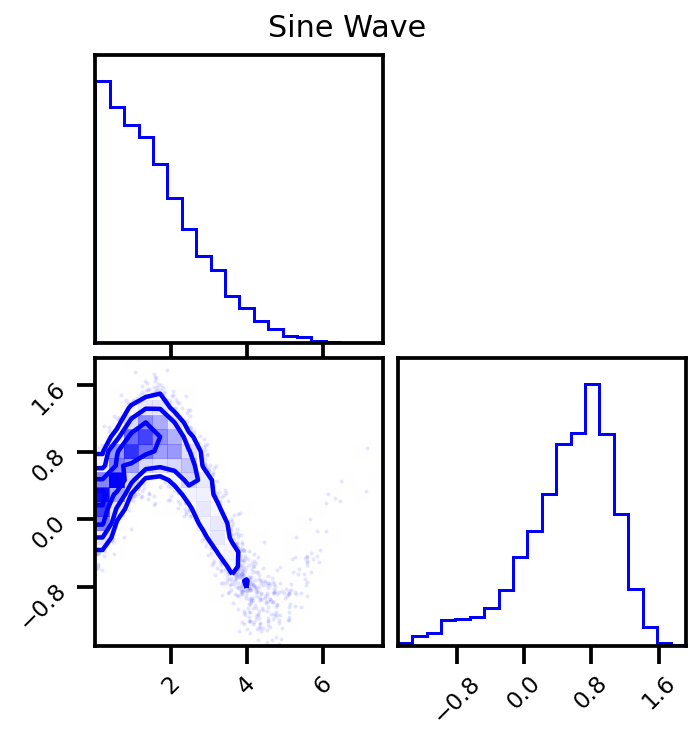

In [ ]:
fig = corner.corner(X, color="blue")
fig.suptitle("Sine Wave")
plt.show()

## Model

In [ ]:
from survae.transforms.bijections.elementwise_nonlinear import GaussianMixtureCDF, InverseGaussCDF
from survae.transforms.bijections.linear_orthogonal import LinearHouseholder

from survae.distributions import StandardUniform, StandardNormal
from survae.flows import Flow
import pytorch_lightning as pl

### Naive GF Initialization

In [ ]:



    
def init_gf_layers(num_mixtures: int, num_layers: int=5, num_reflections: int=2, **kwargs):

    
    transforms = []

    with trange(num_layers) as pbar:

        for ilayer in pbar:

            # MARGINAL UNIFORMIZATION
            ilayer = GaussianMixtureCDF(shape, num_mixtures=num_mixtures)

            # save layer
            transforms.append(ilayer)

            # ELEMENT-WISE INVERSE GAUSSIAN CDF
            ilayer = InverseGaussCDF()

            # save layer
            transforms.append(ilayer)


            # HOUSEHOLDER TRANSFORM
            ilayer = LinearHouseholder(shape[0], num_householder=num_reflections)

            # save layer
            transforms.append(ilayer)


    return transforms

In [ ]:
shape = (2,)

# base distribution
base_dist = StandardNormal(shape)

# init GF
transforms = init_gf_layers(shape=shape, num_mixtures=6, num_layers=12, num_householder=2)




# flow model
model = Flow(
    base_dist=base_dist,
    transforms=transforms
)

  0%|          | 0/12 [00:00<?, ?it/s]

## Training

### Dataset

In [ ]:
# # Data
X_train = get_toy_data(10_000, 123)

train_loader = DataLoader(torch.Tensor(X_train), batch_size=128, shuffle=True)


### Loss

In [ ]:
def nll_loss(model, data):
    return - model.log_prob(data).mean()

### Pytorch-Lightning Trainer

In [ ]:
import pytorch_lightning as pl

class Learner2DPlane(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        
        # loss function
        # loss = -self.model.log_prob(batch).mean()
        loss = nll_loss(self.model, batch)
        
        self.log("train_loss", loss)
        
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-2)

    def train_dataloader(self):
        return train_loader

In [ ]:
# initialize trainer
learn = Learner2DPlane(model)

In [ ]:
n_epochs = 20
logger = TensorBoardLogger("tb_logs", name='mg_no_init')

# initialize trainer
trainer = pl.Trainer(min_epochs=1, max_epochs=n_epochs, gpus=1, enable_progress_bar=True, logger=logger)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


### Logging

In [1]:
# %load_ext tensorboard
# %tensorboard --logdir tb_logs/

### Training

In [ ]:
# train model
trainer.fit(learn, )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Flow | 480   
-------------------------------
480       Trainable params
0         Non-trainable params
480       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Results


### Latent Domain

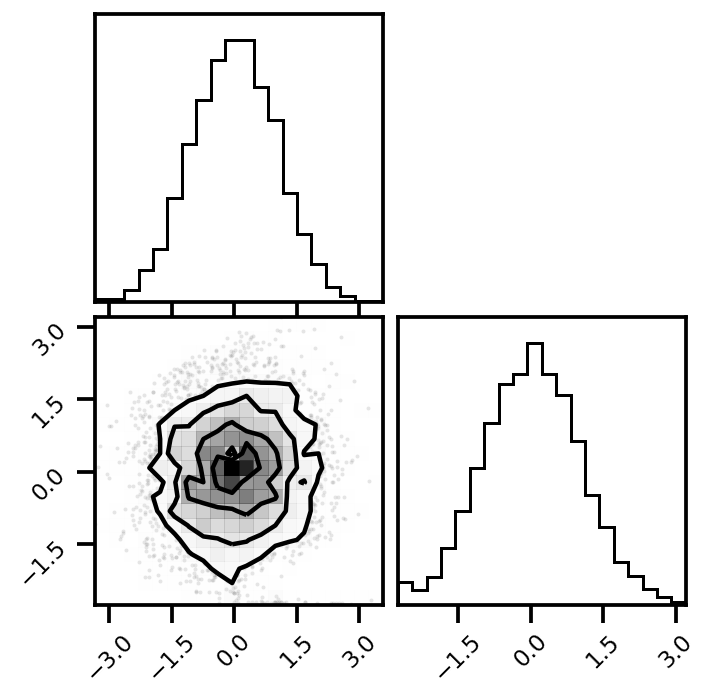

In [ ]:
with torch.no_grad():
    X_ = torch.Tensor(X)
    X_ = X_.to(learn.device)
    X_r, ldj = learn.model.forward_transform(X_)


fig = corner.corner(torch_2_numpy(X_r))

### Inverse

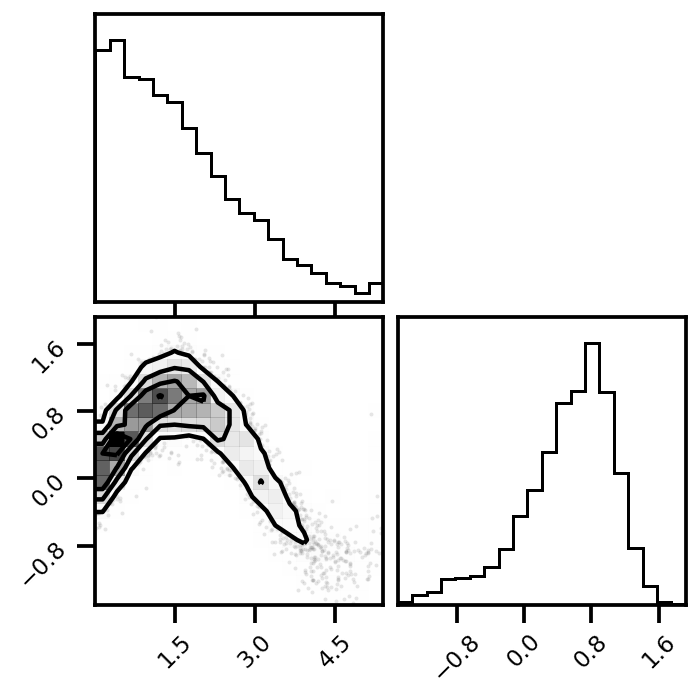

In [ ]:
with torch.no_grad():
    # X_ = X_.to(device)
    X_approx = learn.model.inverse_transform(X_r)

fig = corner.corner(torch_2_numpy(X_approx))

### Samples

In [ ]:
X_samples = learn.model.sample(5_000)

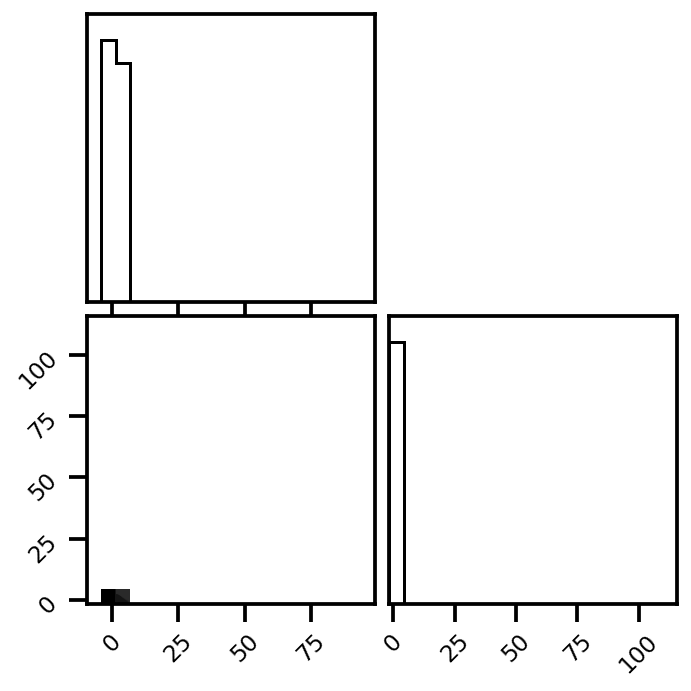

In [ ]:
fig = corner.corner(torch_2_numpy(X_samples))

### Log Probability

## Better Initialization

Notice how we did not actually initialize the layers with the best parameters using the data.

In [ ]:
def init_gf_layers_rbig(shape: Tuple[int], num_mixtures: int, num_reflections: int=2, num_layers: int=5, X=None, **kwargs):

    
    transforms = []

    X = torch.Tensor(X)

    with trange(num_layers) as pbar:

        for ilayer in pbar:

            # MARGINAL UNIFORMIZATION
            ilayer = GaussianMixtureCDF(shape, X=torch_2_numpy(X), num_mixtures=num_mixtures)

            # forward transform
            X, _ = ilayer.forward(X)

            # save layer
            transforms.append(ilayer)

            # ELEMENT-WISE INVERSE GAUSSIAN CDF
            ilayer = InverseGaussCDF()

            # forward transform
            X, _ = ilayer.forward(X)

            # save layer
            transforms.append(ilayer)

            # ELEMENT-WISE INVERSE GAUSSIAN CDF
            ilayer = LinearHouseholder(shape[0], num_householder=num_reflections)

            # forward transform
            X, _ = ilayer.forward(X)

            # save layer
            transforms.append(ilayer)


    return transforms

In [ ]:
shape = (2,)

# base distribution
base_dist = StandardNormal(shape)

# init GF
transforms = init_gf_layers_rbig(shape=shape, X=X, num_mixtures=6, num_layers=12, num_householder=2)




# flow model
model = Flow(
    base_dist=base_dist,
    transforms=transforms
)

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:



# initialize trainer
learn = Learner2DPlane(model)

In [ ]:
n_epochs = 20
logger = TensorBoardLogger("tb_logs", name='mg_rbig_init')

# initialize trainer
trainer = pl.Trainer(min_epochs=1, max_epochs=n_epochs, gpus=1, enable_progress_bar=True, logger=logger)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
# train model
trainer.fit(learn, )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Flow | 480   
-------------------------------
480       Trainable params
0         Non-trainable params
480       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

## Results


### Latent Domain

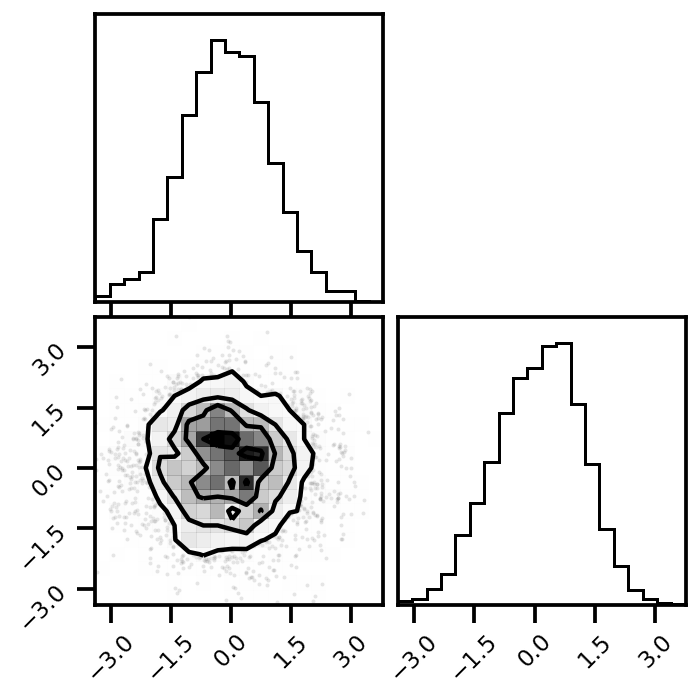

In [ ]:
with torch.no_grad():
    X_ = torch.Tensor(X)
    X_ = X_.to(learn.device)
    X_r, ldj = learn.model.forward_transform(X_)


fig = corner.corner(torch_2_numpy(X_r))

### Inverse

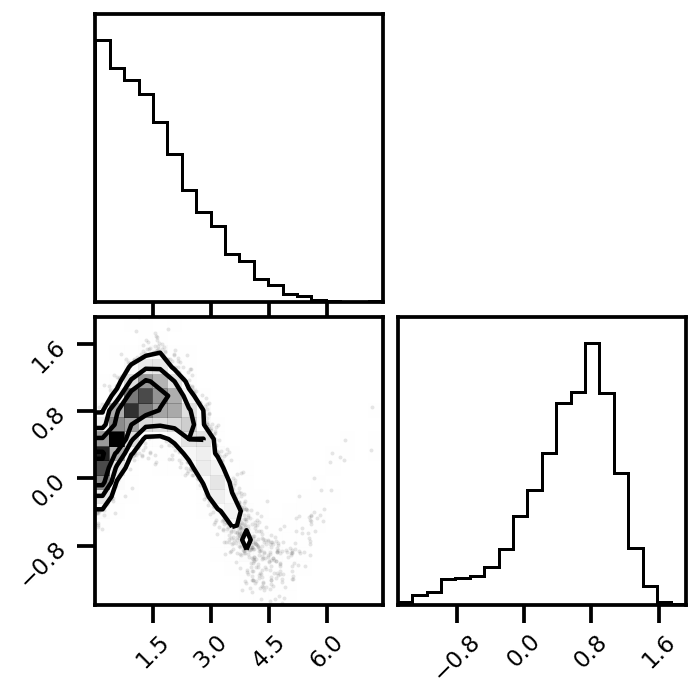

In [ ]:
with torch.no_grad():
    # X_ = X_.to(device)
    X_approx = learn.model.inverse_transform(X_r)

fig = corner.corner(torch_2_numpy(X_approx))

### Samples

In [ ]:
X_samples = learn.model.sample(5_000)

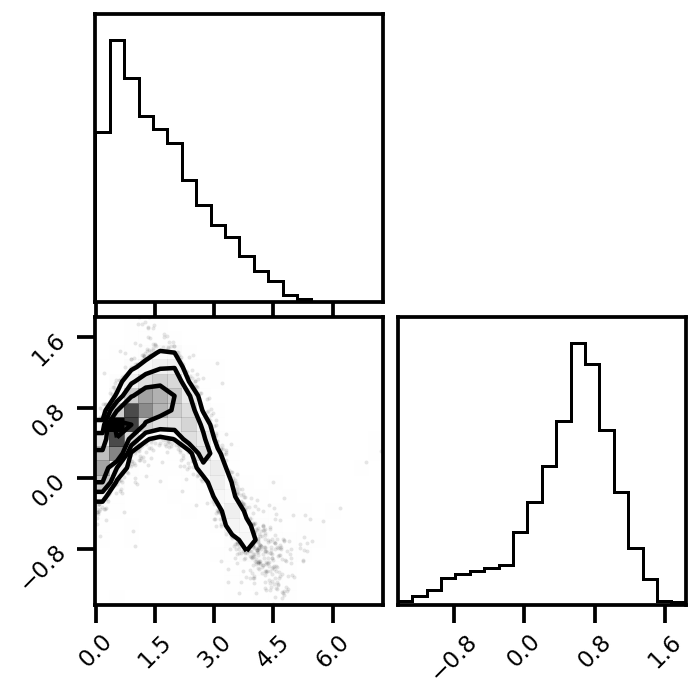

In [ ]:
fig = corner.corner(torch_2_numpy(X_samples))

### Log Probability

In [ ]:
def generate_2d_grid(data: np.ndarray, n_grid: int = 1_000, buffer: float = 0.01) -> np.ndarray:

    xline = np.linspace(data[:, 0].min() - buffer, data[:, 0].max() + buffer, n_grid)
    yline = np.linspace(data[:, 1].min() - buffer, data[:, 1].max() + buffer, n_grid)
    xgrid, ygrid = np.meshgrid(xline, yline)
    xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)
    return xyinput

In [ ]:
# sampled data
xyinput = generate_2d_grid(X, 500, buffer=0.1)

In [ ]:
from matplotlib import cm

def plot_2d_grid(X_plot, X_grid, X_log_prob):



    # Estimated Density
    cmap = cm.magma  # "Reds"
    probs = np.exp(X_log_prob)
    # probs = np.clip(probs, 0.0, 1.0)
    # probs = np.clip(probs, None, 0.0)


    cmap = cm.magma  # "Reds"
    # cmap = "Reds"

    fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
    h = ax[0].hist2d(
        X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
    )
    ax[0].set_title("True Density")
    ax[0].set(
        xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
        ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
    )


    h1 = ax[1].scatter(
        X_grid[:, 0], X_grid[:, 1], s=1, c=probs, cmap=cmap, #vmin=0.0, vmax=1.0
    )
    ax[1].set(
        xlim=[X_grid[:, 0].min(), X_grid[:, 0].max()],
        ylim=[X_grid[:, 1].min(), X_grid[:, 1].max()],
    )
    # plt.colorbar(h1)
    ax[1].set_title("Estimated Density")


    plt.tight_layout()
    plt.show()
    return fig, ax


In [ ]:
with torch.no_grad():
    X_ = torch.Tensor(xyinput)
    # X_ = X_.to(device)
    X_log_prob = learn.model.log_prob(X_)

X_log_prob = torch_2_numpy(X_log_prob)

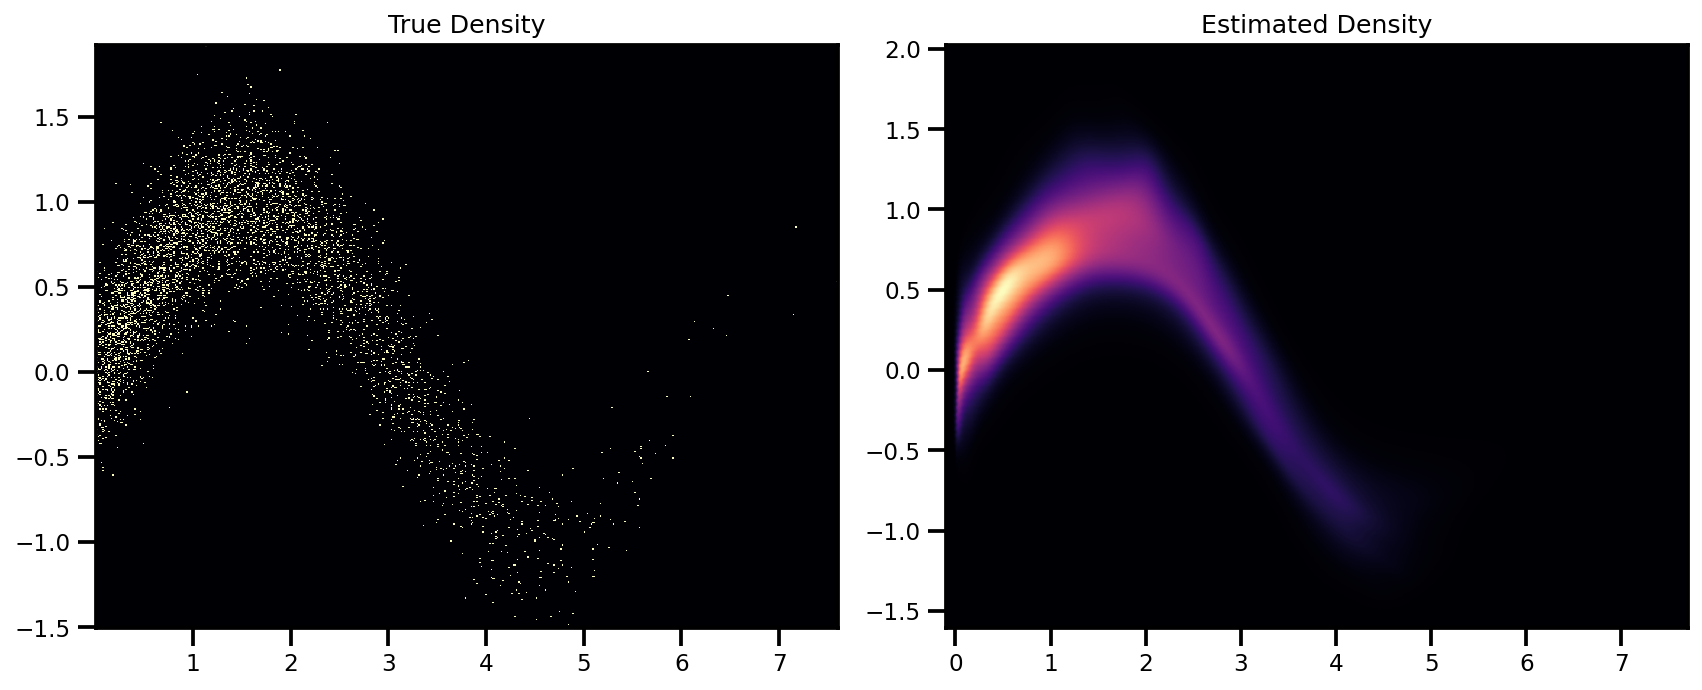

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f907c65dc10>,
       dtype=object))

In [ ]:
plot_2d_grid(torch_2_numpy(X), torch_2_numpy(xyinput), torch_2_numpy(X_log_prob))